In [5]:
import numpy as np

## 損失関数

In [8]:
t = np.array([0,   0,   1,   0,   0, 0])
y = np.array([0.1, 0, 0.5, 0.3, 0.1, 0])

### 2乗和誤差

In [6]:
def mean_squared_error(y, t):
    return np.sum((y-t) ** 2)

In [9]:
mean_squared_error(y, t)

0.36

### 交差エントロピー誤差

In [2]:
def cross_entolopy_error(y, t):
    return -np.sum(t * np.log(y + 1e-7))

In [10]:
cross_entolopy_error(y, t)

0.6931469805599654

## ニューラルネットの実装

### 単層

In [13]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)
    
    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        return cross_entropy_error(y, t)

In [14]:
net = simpleNet()
print(net.W)

[[ 1.38839435 -0.53941133  0.29062634]
 [-1.03457534  0.91563476 -0.45386401]]


In [16]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.0980812   0.50042449 -0.2341018 ]


In [17]:
np.argmax(p)

1

In [18]:
t = np.array([0, 1, 0])
net.loss(x, t)

0.7077227353480716

In [23]:
dW = numerical_gradient(lambda _: net.loss(x, t), net.W)
print(dW)

[[ 0.16251082 -0.30434576  0.14183494]
 [ 0.24376623 -0.45651863  0.21275241]]


### 二層ニューラルネット

In [82]:
from common.functions import *

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        init_weight = lambda s1, s2: weight_init_std * np.random.randn(s1, s2)
        init_bias = lambda s: np.zeros(s)

        self.params = {}
        self.params['W1'] = init_weight(input_size, hidden_size)
        self.params['b1'] = init_bias(hidden_size)
        self.params['W2'] = init_weight(hidden_size, output_size)
        self.params['b2'] = init_bias(output_size)

    def predict(self, x):
        a1 = np.dot(x, self.params['W1']) + self.params['b1']
        z1 = sigmoid(a1)
        a2 = np.dot(z1, self.params['W2']) + self.params['b2']
        z2 = sigmoid(a2)
        return softmax(z2)

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entolopy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

    def numerical_gradient(self, x, t):
        loss_W = lambda _: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [77]:
net = TwoLayerNet(784, 100, 10)

In [78]:
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [94]:
x = np.random.rand(100, 784)
y = net.predict(x)
print(y[:5])

[[0.14010363 0.05658374 0.14452334 0.14891865 0.05549649 0.14372195
  0.06307983 0.0574474  0.13345181 0.05667316]
 [0.13422833 0.05590135 0.14145693 0.14858679 0.05543568 0.13686032
  0.05665127 0.05655022 0.14713692 0.06719219]
 [0.14357211 0.05519589 0.14227036 0.1469957  0.05484734 0.14237417
  0.05589365 0.05909911 0.14122999 0.05852169]
 [0.13862831 0.05591326 0.14651127 0.1483115  0.05509461 0.1348075
  0.05685635 0.05654847 0.1443866  0.06294212]
 [0.13566735 0.05612508 0.14121807 0.14726631 0.05655068 0.14239387
  0.05748457 0.05660865 0.14830195 0.05838349]]


## 確率的勾配降下法 (Stochastic Gradient Decent)

In [99]:
from dataset.mnist import load_mnist

train, test = load_mnist(normalize=True, one_hot_label=True)
x_train, t_train = train
x_test, t_test = test

In [118]:
# hyper parameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
n_epoch = iters_num // batch_size
lr = 0.1 # learning rate

In [119]:
net = TwoLayerNet(784, 50, 10)

In [120]:
train_losses, train_accs, test_accs = [], [], []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= lr * grad[key]

    loss = net.loss(x_batch, t_batch)
    train_losses.append(loss)

    if i % n_epoch == 0:
        train_acc = net.accuracy(x_train, t_train)
        train_accs.append(train_acc)
        test_acc = net.accuracy(x_test, t_test)
        test_accs.append(test_acc)
    if i % 1000 == 0:
        print(f'train acc: {train_acc:.5f} / test acc: {test_acc:.5f}')

train acc: 0.09752 / test acc: 0.09740
train acc: 0.86413 / test acc: 0.87050
train acc: 0.90280 / test acc: 0.90750
train acc: 0.91498 / test acc: 0.91740
train acc: 0.92217 / test acc: 0.92440
train acc: 0.92905 / test acc: 0.93030
train acc: 0.93437 / test acc: 0.93530
train acc: 0.93757 / test acc: 0.93730
train acc: 0.94142 / test acc: 0.94020
train acc: 0.94437 / test acc: 0.94270


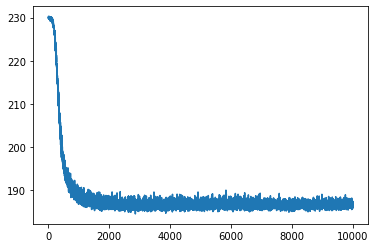

In [121]:
import matplotlib.pyplot as plt
plt.plot(range(iters_num), train_losses)

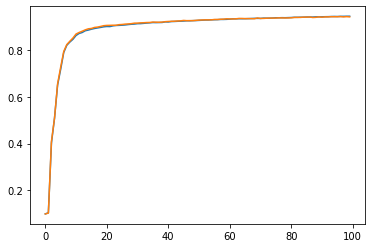

In [123]:
plt.plot(range(n_epoch), train_accs)
plt.plot(range(n_epoch), test_accs)